In [1]:
import numpy as np 
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,classification_report
from keras import callbacks,Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential



In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head(15)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


[Text(0, 0, '203'), Text(0, 0, '96')]

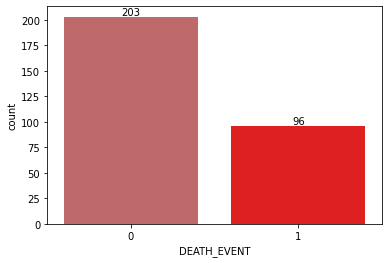

In [4]:
# finding out the potential skewness in the data
cols= ["#CD5C5C","#FF0000"]
ax = sns.countplot(x= df["DEATH_EVENT"], palette= cols)
ax.bar_label(ax.containers[0])

In [5]:
x=  df.drop(["DEATH_EVENT"],axis=1)
y=  df["DEATH_EVENT"]

In [6]:
s_scaler = preprocessing.StandardScaler()
X_scaled= s_scaler.fit_transform(x)


In [7]:
# For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [73]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=79,stratify=y)

#for cross validation check dividing training data again

x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train, test_size=0.2, random_state=32,stratify=y_train)

In [68]:
from keras import backend as K


# defining different metrics for evaluating our lstm model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [74]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=15, 
    restore_best_weights=True)

# Initializing the NN
model = Sequential()

model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy',f1_m,recall_m,precision_m])



In [75]:
# Training the ANN
N_Network = model.fit(x_train, y_train, batch_size = 32, epochs = 15,callbacks=[early_stopping],validation_data=(x_valid,y_valid))

Epoch 1/15
6/6 [==============================] - 0s 78ms/step - loss: 0.6926 - accuracy: 0.6597 - f1_m: 0.0303 - recall_m: 0.0278 - precision_m: 0.0333 - val_loss: 0.6916 - val_accuracy: 0.6875 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/15
6/6 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6754 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.6897 - val_accuracy: 0.6875 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/15
6/6 [==============================] - 0s 6ms/step - loss: 0.6888 - accuracy: 0.6754 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.6871 - val_accuracy: 0.6875 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 4/15
6/6 [==============================] - 0s 8ms/step - loss: 0.6858 - accuracy: 0.6754 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 

In [76]:
model.evaluate(x_test,y_test, batch_size = 128, verbose = 2)

1/1 - 0s - loss: 0.3851 - accuracy: 0.8167 - f1_m: 0.6452 - recall_m: 0.5263 - precision_m: 0.8333


[0.3850995898246765,
 0.8166666626930237,
 0.6451612114906311,
 0.5263158082962036,
 0.8333333134651184]

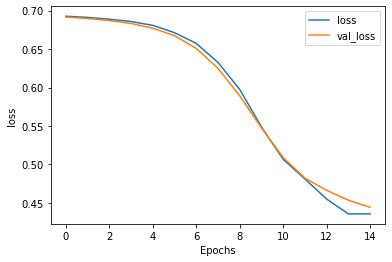

In [77]:
plot_graphs(N_Network,"loss")

In [78]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.4)
np.set_printoptions()

<AxesSubplot:>

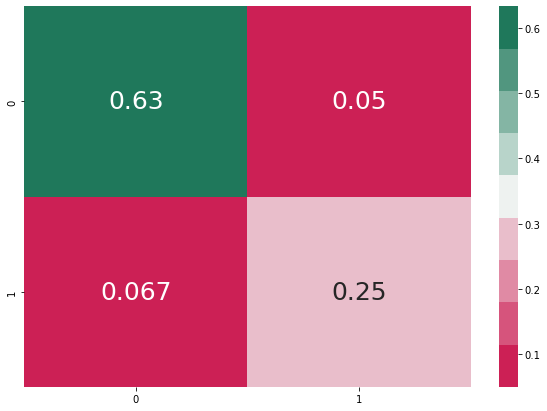

In [79]:
# Getting the confusion matrix
cmap1 = sns.diverging_palette(2, 155, s=90, l=45, n=9)
plt.subplots(figsize=(10,7))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':25})

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        41
           1       0.83      0.79      0.81        19

    accuracy                           0.88        60
   macro avg       0.87      0.86      0.86        60
weighted avg       0.88      0.88      0.88        60



Counter Factual method based on 1NN baseline

In [81]:
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [82]:
# Get the predicted target class: if pred > 0.5, then y_pred = 1; else, y_pred = 0
y_pred = np.array([1 if pred > 0.5 else 0 for pred in model.predict(x_valid)])

In [97]:
# Get these instances of negative predictions
X_pred_negative = x_valid[y_pred == 1]

print('1st negative prediction',X_pred_negative[0])
print('X_neg_predict shape', X_pred_negative.shape)

1st negative prediction [ 0.0981993  -0.87110478 -0.36218903 -0.84757938 -1.10736987  1.35927151
 -0.10608328 -0.47820469  0.76606383  0.73568819  1.4541607  -1.55206738]
X_neg_predict shape (6, 12)


In [99]:
# Use the index of negative predictions to find the original row with the diagnosis codes
# np.where(y_pred == 0)
pred_neg_data = df.iloc[np.where(y_pred == 1)]

pred_neg_data.head(2)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
6,75.0,1,246,0,15,0,127000.0,1.2,137,1,0,10,1
11,62.0,0,231,0,25,1,253000.0,0.9,140,1,1,10,1


In [102]:
# Fit an unsupervised 1NN with all the positive seuquences, using 'hamming' distance
neural_model = NearestNeighbors(1, metric='hamming')

target_label = 0 
X_target_label = x_train[y_train == target_label] # training using the true labels

neural_model.fit(X_target_label)

C:\Users\Kamran\anaconda3\envs\sum_int\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


NearestNeighbors(metric='hamming', n_neighbors=1)

In [101]:
# Find the closest neighbor (positive sequence) with the minimum 'hamming' distance, take it as a counterfactual
closest = neural_model.kneighbors(X_pred_negative, return_distance=False)
trans_results_nn = X_target_label[closest[:, 0]]
print(trans_results_nn.shape)
print('closest counter to the negative prediction that can change it into a positive one',trans_results_nn[0])

(6, 12)
closest counter to the negative prediction that can change it into a positive one [-9.12335403e-01 -8.71104775e-01  1.65728387e-04 -8.47579380e-01
  2.02423362e+00  1.35927151e+00 -1.19169784e+00 -5.75030855e-01
  7.66063830e-01  7.35688190e-01  1.45416070e+00  7.96795258e-01]


In [94]:
x_test_counter =  trans_results_nn

Fraction of valid transformed input for 1NN baseline method

In [46]:
# Get the total counts 
test_size = X_pred_negative.shape[0]
test_size

38

In [49]:
# For 1NN modification
fraction_success = np.sum(model.predict(x_test_counter) > 0.5)/test_size
print(round(fraction_success, 4))


0.5263


LOCAL OUTLIER FACTOR 

In [51]:
# Fit the model for novelty detection (novelty=True), in order to get LOF score
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
# clf.fit(X_train_padded)
clf.fit(X_target_label) # use the target class to train, instead of all

LocalOutlierFactor(contamination=0.1, novelty=True)

In [53]:
# Outlier score for 1NN baseline method
y_pred_test = clf.predict(x_test_counter)
n_error_test = y_pred_test[y_pred_test == -1].size
outlier_score_test = n_error_test / test_size
print(round(outlier_score_test, 4))

0.2632


EDIT DISTANCE (LEVENSHTEIN)

In [61]:
import editdistance

In [59]:
def get_edit_distance(original, transformed):
    edit_distance_pair = [editdistance.eval(o, t) for o, t in zip(original.tolist(), transformed.tolist())]
    edit_score = np.mean(edit_distance_pair)
    
    return round(edit_score, 4)

In [62]:
get_edit_distance(x_test_counter, X_pred_negative)

6.0526